# Modelo 2 - Pruebas

In [2]:
import os, sys
sys.path.append(os.path.abspath("../"))
import optuna
import numpy as np
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CARGA DE DATASET Y DIVISIÓN TRAIN/TEST
---

In [ ]:
# Se carga el dataset de trabajo
df = pd.read_csv("../data/Datos_Reservas_full.csv")

# Se separa los conjuntos de datos de train y test
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

# Se identifica el target
target = "canceled"

### TRANSFORMACIONES
---

In [ ]:
# TRAIN
#---------------------------- CAMBIO 1-----------------------------------------
# ELIMINACIÓN DE REGISTROS DE PROMOCIONES, DEVOLUCIONES Y POSIBLES ERRORES
# TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'daily_price'
train_set = train_set.drop(train_set[train_set["daily_price"] <= 0].index, axis = 0)
train_set = train_set.drop(train_set[train_set["daily_price"] > 2000].index, axis = 0)
train_set["daily_price"] = np.log10(train_set["daily_price"])
#---------------------------- CAMBIO 2-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES Y TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'lead_time'
train_set = train_set.drop(train_set[train_set["lead_time"] <= 0].index, axis = 0)
train_set["lead_time"] = np.log10(train_set["lead_time"])
#---------------------------- CAMBIO 3-----------------------------------------
# ELIMINACIÓN DE REGISTROS CON VALOR 0 COINCIDENTES EN LAS COLUMNAS 'adults' Y 'children'
train_set = train_set.drop(train_set[(train_set["adults"] == 0)&(train_set["children"] == 0)].index, axis = 0)
#---------------------------- CAMBIO 4-----------------------------------------
# TRANSFORMACIÓN DE 'children' A CATEGÓRICA BINARIA
train_set.loc[train_set["children"] > 0, "children"] = 1
#---------------------------- CAMBIO 5-----------------------------------------
# TRANSFORMACIÓN DE 'total_book' A CATEGÓRICA BINARIA
train_set.loc[train_set["total_book"] > 0, "total_book"] = 1
#---------------------------- CAMBIO 6-----------------------------------------
# TRANSFORMACIÓN DE 'pre_cancel' Y 'pre_not_cancel' A CATEGÓRICA BINARIA
train_set.loc[train_set["pre_cancel"] > 0, "pre_cancel"] = 1
train_set.loc[train_set["pre_not_cancel"] > 0, "pre_not_cancel"] = 1

#---------------------------- CAMBIO 7-----------------------------------------
# ELIMINACIÓN DE 'arr_date'
train_set.drop(columns = ["arr_date"], inplace = True)
#---------------------------- CAMBIO 8-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES COINCIDENTES EN LAS COLUMNAs 'week_nights' y 'weekend_nights'
# TRANSFORMACIÓN DE ETIQUETAS PARA UNIFICAR LOS VALORES POR ENCIMA DE 5 EN 'week_nights' Y POR ENCIMA DE 2 EN 'weekend_nights'
train_set = train_set.drop(train_set[(train_set["week_nights"] == 0)&(train_set["weekend_nights"] == 0)].index, axis = 0)
train_set.loc[train_set["week_nights"] > 5, "week_nights"] = 6
train_set.loc[train_set["weekend_nights"] > 2, "weekend_nights"] = 3
#---------------------------- CAMBIO 9-----------------------------------------
# TRANSFORMACIÓN DE 'meal_plan' A VARIABLE NUMÉRICA CON ORDINAL ENCODER
encoder = OrdinalEncoder(categories=[["SC","RO","BB","HB","FB"]])
train_set[["meal_plan"]] = encoder.fit_transform(train_set[["meal_plan"]])
#---------------------------- CAMBIO 10-----------------------------------------
# TRANSFORMACIÓN DE 'parking' A VARIABLE BINARIA
train_set.loc[train_set["parking"] > 0, "parking"] = 1


# TEST
#---------------------------- CAMBIO 1-----------------------------------------
# ELIMINACIÓN DE REGISTROS DE PROMOCIONES, DEVOLUCIONES Y POSIBLES ERRORES
# TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'daily_price'
test_set = test_set.drop(test_set[test_set["daily_price"] <= 0].index, axis = 0)
test_set = test_set.drop(test_set[test_set["daily_price"] > 2000].index, axis = 0)
test_set["daily_price"] = np.log10(test_set["daily_price"])
#---------------------------- CAMBIO 2-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES Y TRANSFORMACIÓN LOGÍSTICA A LA COLUMNA 'lead_time'
test_set = test_set.drop(test_set[test_set["lead_time"] <= 0].index, axis = 0)
test_set["lead_time"] = np.log10(test_set["lead_time"])
#---------------------------- CAMBIO 3-----------------------------------------
# ELIMINACIÓN DE REGISTROS CON VALOR 0 COINCIDENTES EN LAS COLUMNAS 'adults' Y 'children'
test_set = test_set.drop(test_set[(test_set["adults"] == 0)&(test_set["children"] == 0)].index, axis = 0)
#---------------------------- CAMBIO 4-----------------------------------------
# TRANSFORMACIÓN DE 'children' A CATEGÓRICA BINARIA
test_set.loc[test_set["children"] > 0, "children"] = 1
#---------------------------- CAMBIO 5-----------------------------------------
# TRANSFORMACIÓN DE 'total_book' A CATEGÓRICA BINARIA
test_set.loc[test_set["total_book"] > 0, "total_book"] = 1
#---------------------------- CAMBIO 6-----------------------------------------
# TRANSFORMACIÓN DE 'pre_cancel' Y 'pre_not_cancel' A CATEGÓRICA BINARIA
test_set.loc[test_set["pre_cancel"] > 0, "pre_cancel"] = 1
test_set.loc[test_set["pre_not_cancel"] > 0, "pre_not_cancel"] = 1

#---------------------------- CAMBIO 7-----------------------------------------
# ELIMINACIÓN DE 'arr_date'
test_set.drop(columns = ["arr_date"], inplace = True)
#---------------------------- CAMBIO 8-----------------------------------------
# ELIMINACIÓN DE VALORES INCONSISTENTES COINCIDENTES EN LAS COLUMNAs 'week_nights' y 'weekend_nights'
# TRANSFORMACIÓN DE ETIQUETAS PARA UNIFICAR LOS VALORES POR ENCIMA DE 5 EN 'week_nights' Y POR ENCIMA DE 2 EN 'weekend_nights'
test_set = test_set.drop(test_set[(test_set["week_nights"] == 0)&(test_set["weekend_nights"] == 0)].index, axis = 0)
test_set.loc[test_set["week_nights"] > 5, "week_nights"] = 6
test_set.loc[test_set["weekend_nights"] > 2, "weekend_nights"] = 3
#---------------------------- CAMBIO 9-----------------------------------------
# TRANSFORMACIÓN DE 'meal_plan' A VARIABLE NUMÉRICA CON ORDINAL ENCODER
encoder = OrdinalEncoder(categories=[["SC","RO","BB","HB","FB"]])
test_set[["meal_plan"]] = encoder.fit_transform(test_set[["meal_plan"]])
#---------------------------- CAMBIO 10-----------------------------------------
# TRANSFORMACIÓN DE 'parking' A VARIABLE BINARIA
test_set.loc[test_set["parking"] > 0, "parking"] = 1

In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115166 entries, 7740 to 121958
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   daily_price     115166 non-null  float64
 1   lead_time       115166 non-null  float64
 2   adults          115166 non-null  int64  
 3   children        115166 non-null  int64  
 4   repeated_guest  115166 non-null  int64  
 5   total_book      115166 non-null  int64  
 6   pre_cancel      115166 non-null  int64  
 7   pre_not_cancel  115166 non-null  int64  
 8   arr_week        115166 non-null  int64  
 9   week_nights     115166 non-null  int64  
 10  weekend_nights  115166 non-null  int64  
 11  meal_plan       115166 non-null  float64
 12  parking         115166 non-null  int64  
 13  special_req     115166 non-null  int64  
 14  canceled        115166 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 14.1 MB


In [6]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
daily_price,115166.0,1.981351,0.187378,-0.585027,1.875061,1.984797,2.100371,2.732394
lead_time,115166.0,1.720934,0.630012,0.000000,1.380211,1.863323,2.201397,2.850646
adults,115166.0,1.868763,0.484971,0.000000,2.000000,2.000000,2.000000,4.000000
children,115166.0,0.074119,0.261966,0.000000,0.000000,0.000000,0.000000,1.000000
repeated_guest,115166.0,0.021864,0.146240,0.000000,0.000000,0.000000,0.000000,1.000000
total_book,115166.0,0.063092,0.243129,0.000000,0.000000,0.000000,0.000000,1.000000
pre_cancel,115166.0,0.045065,0.207448,0.000000,0.000000,0.000000,0.000000,1.000000
pre_not_cancel,115166.0,0.022567,0.148520,0.000000,0.000000,0.000000,0.000000,1.000000
arr_week,115166.0,27.690968,13.411711,1.000000,17.000000,28.000000,39.000000,53.000000
week_nights,115166.0,2.422972,1.469079,0.000000,1.000000,2.000000,3.000000,6.000000


### DIVISIÓN DE SUBCONJUNTOS X,Y
---

In [7]:
# Se forman los subconjuntos X,y
X_train = train_set.copy()
X_train.drop(columns = [target], inplace = True)
y_train = train_set[target].copy()

X_test = test_set.copy()
X_test.drop(columns = [target], inplace = True)
y_test = test_set[target].copy()

### GENERACIÓN DE BASELINE
---

In [8]:
# Escalado (StandarScaler) aplicado a Logistic Regression
model_names = ["DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
clf_DT = DecisionTreeClassifier(random_state = 42)
clf_RF = RandomForestClassifier(random_state = 42)
clf_XG = XGBClassifier(random_state = 42)
clf_LG = LGBMClassifier(random_state = 42, verbose = -100)
clf_CA = CatBoostClassifier(random_state = 42, verbose = False)
model_set = [clf_DT, clf_RF, clf_XG, clf_LG, clf_CA]

metricas_cv = {}
valores = []
for name,model in zip(model_names, model_set):
    print(model)
    metricas_cv[name] = cross_val_score(model, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
    valores.append(np.mean(metricas_cv[name]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El modelo con mejor métrica es {ganador}")

DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
LGBMClassifier(random_state=42, verbose=-100)
Model <DecisionTree>, Accuracy_CV: 0.8032390341767984
Model <Random Forest>, Accuracy_CV: 0.8269911107208141
Mode

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     17799
           1       0.83      0.77      0.80     11025

    accuracy                           0.85     28824
   macro avg       0.85      0.84      0.84     28824
weighted avg       0.85      0.85      0.85     28824



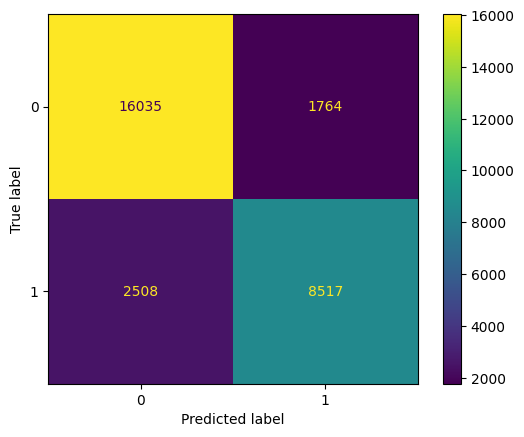

In [9]:
# Entrenar modelo
clf_RF.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF = clf_RF.predict(X_test)
print(classification_report(y_test, y_pred_RF))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF);

### BALANCEO DE TARGET
---

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     17799
           1       0.76      0.83      0.80     11025

    accuracy                           0.84     28824
   macro avg       0.83      0.84      0.83     28824
weighted avg       0.84      0.84      0.84     28824



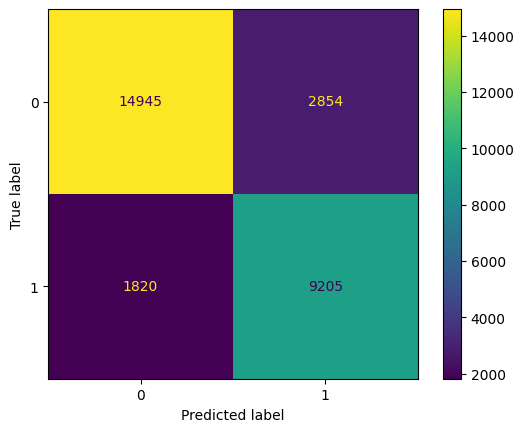

In [10]:
# Se balancea el target empleando un undersampling (resample)

feature_w = X_train[y_train == 0]
feature_l = X_train[y_train == 1]
feature_w_us = resample(feature_w, replace = False, n_samples = len(feature_l), random_state = 42)
X_train_us = pd.concat([feature_w_us, feature_l])
y_train_us = pd.concat([y_train.loc[feature_w_us.index], y_train.loc[feature_l.index]])

# Entrenar el modelo con los datos bajomuestreados
clf_RF_us = RandomForestClassifier(random_state = 42)
clf_RF_us.fit(X_train_us, y_train_us)

# Realizar predicciones y evaluar el modelo
y_pred_RF_us = clf_RF_us.predict(X_test)
print(classification_report(y_test, y_pred_RF_us))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_us);

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     17799
           1       0.82      0.78      0.80     11025

    accuracy                           0.85     28824
   macro avg       0.85      0.84      0.84     28824
weighted avg       0.85      0.85      0.85     28824



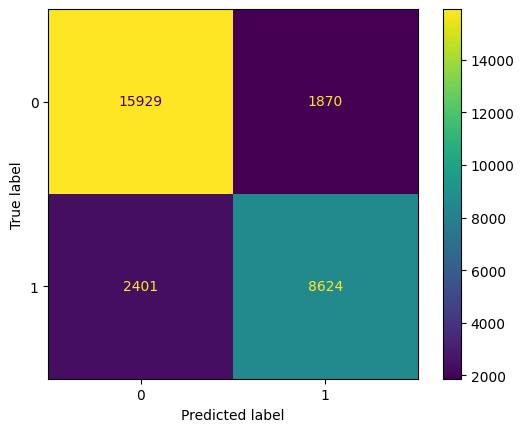

In [11]:
# Se balancea el target empleando 'class_weight'

# Entrenar el modelo indicando 'class_weight'
clf_RF_cw = RandomForestClassifier(random_state = 42, class_weight = "balanced")
clf_RF_cw.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_cw = clf_RF_cw.predict(X_test)
print(classification_report(y_test, y_pred_RF_cw))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_cw);

In [ ]:
# # Optimización de parámetros por GridSearchCV

# parameters = {
#     "criterion": ["gini","entropy","log_loss"],
#     "n_estimators": [100,200,300,400],
#     "max_depth": [None],
#     "min_samples_leaf": [1,2,4],
#     "min_samples_split": [2,5,10],
#     "max_features": ["sqrt","log2",None]}

# grid_RF = GridSearchCV(clf_RF_cw,
#                        param_grid = parameters,
#                        cv = 5,
#                        scoring = "balanced_accuracy",
#                        n_jobs = -1)

In [14]:
# # Entrenar el modelo indicando los mejores parámetros
# grid_RF.fit(X_train, y_train)
# print(grid_RF.best_score_)
# print(grid_RF.best_params_)

# # Realizar predicciones y evaluar el modelo
# y_pred_RF_gs = grid_RF.best_estimator_.predict(X_test)
# print(classification_report(y_test, y_pred_RF_gs))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_gs)

In [17]:
# Optimización de parámetros mediante Optuna

def objective(trial):
    # Suggest values for hyperparameters
    criterion = trial.suggest_categorical("criterion", ["gini","entropy","log_loss"])
    n_estimators = trial.suggest_int("n_estimators", 10, 500, log = True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt","log2",None])

    # Create and fit random forest model
    model = RandomForestClassifier(
        criterion = criterion,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        random_state = 42,
        )
        
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

print(f"Best parameters: {study.best_params}")
print(f"Best score: {study.best_value}")

[I 2025-07-01 15:56:36,641] A new study created in memory with name: no-name-34616061-24b5-414e-ac21-68dd8ba30d3a
[I 2025-07-01 15:56:46,887] Trial 0 finished with value: 0.8035317790729948 and parameters: {'criterion': 'gini', 'n_estimators': 174, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.8035317790729948.
[I 2025-07-01 15:56:50,236] Trial 1 finished with value: 0.7565223424923675 and parameters: {'criterion': 'log_loss', 'n_estimators': 87, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8035317790729948.
[I 2025-07-01 15:56:54,590] Trial 2 finished with value: 0.6555995004163198 and parameters: {'criterion': 'entropy', 'n_estimators': 354, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.8035317790729948.
[I 2025-07-01 15:56:57,213] Trial 3 finished with value: 0.8040868

Best parameters: {'criterion': 'log_loss', 'n_estimators': 185, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}
Best score: 0.8545656397446573


              precision    recall  f1-score   support

           0       0.87      0.90      0.88     17799
           1       0.83      0.78      0.80     11025

    accuracy                           0.85     28824
   macro avg       0.85      0.84      0.84     28824
weighted avg       0.85      0.85      0.85     28824



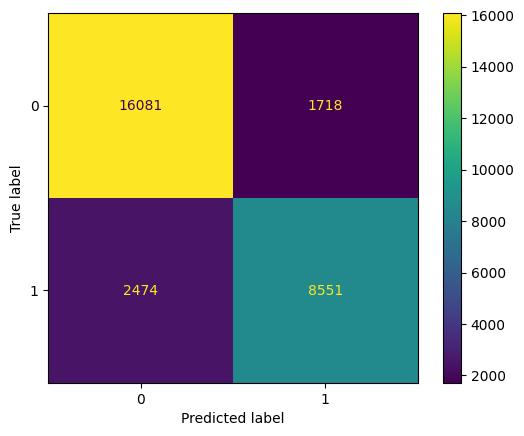

In [19]:
# Entrenar el modelo indicando los mejores parámetros
clf_RF_op = RandomForestClassifier(criterion = "log_loss", n_estimators = 185, max_depth = 27, min_samples_split = 3, min_samples_leaf = 1, max_features = None, random_state = 42)
clf_RF_op.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_op = clf_RF_op.predict(X_test)
print(classification_report(y_test, y_pred_RF_op))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_op);

In [22]:
# Optimización de parámetros mediante Optuna

def objective(trial):
    # Suggest values for hyperparameters
    criterion = trial.suggest_categorical("criterion", ["gini","entropy","log_loss"])
    n_estimators = trial.suggest_int("n_estimators", 10, 500, log = True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt","log2",None])
    class_weight = trial.suggest_categorical("class_weight", ["balanced","balanced_subsample"])

    # Create and fit random forest model
    model = RandomForestClassifier(
        criterion = criterion,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        class_weight = class_weight,
        random_state = 42,
        )
        
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

print(f"Best parameters: {study.best_params}")
print(f"Best score: {study.best_value}")

[I 2025-07-01 17:20:21,284] A new study created in memory with name: no-name-4fd76e6c-7751-4486-884d-ce3a0fef46b2
[I 2025-07-01 17:20:34,732] Trial 0 finished with value: 0.7085414932001111 and parameters: {'criterion': 'gini', 'n_estimators': 414, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7085414932001111.
[I 2025-07-01 17:20:36,581] Trial 1 finished with value: 0.7048640022203719 and parameters: {'criterion': 'log_loss', 'n_estimators': 97, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7085414932001111.
[I 2025-07-01 17:20:39,496] Trial 2 finished with value: 0.7175964474049403 and parameters: {'criterion': 'entropy', 'n_estimators': 110, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 2 with 

Best parameters: {'criterion': 'log_loss', 'n_estimators': 290, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'class_weight': 'balanced'}
Best score: 0.8555023591451568


              precision    recall  f1-score   support

           0       0.88      0.89      0.88     17799
           1       0.82      0.80      0.81     11025

    accuracy                           0.86     28824
   macro avg       0.85      0.84      0.85     28824
weighted avg       0.85      0.86      0.86     28824



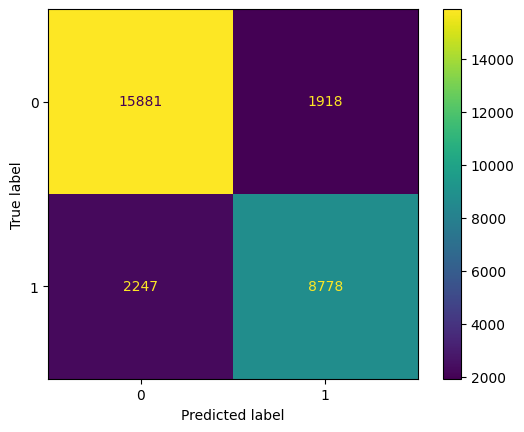

In [24]:
# Entrenar el modelo indicando los mejores parámetros
clf_RF_opcw = RandomForestClassifier(criterion = "log_loss", n_estimators = 290, max_depth = 30, min_samples_split = 2, min_samples_leaf = 1, max_features = None, class_weight = "balanced", random_state = 42)
clf_RF_opcw.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_RF_opcw = clf_RF_opcw.predict(X_test)
print(classification_report(y_test, y_pred_RF_opcw))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_RF_opcw);